In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas

In [3]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit

In [4]:
client = CryptoHistoricalDataClient()

In [5]:
request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USD"],
    timeframe=TimeFrame(amount=15, unit=TimeFrameUnit('Min')),
    #timeframe=TimeFrame.Minute,
    start="2023-05-18",
    end="2024-05-18"
)

btc_bars = client.get_crypto_bars(request_params=request_params)

#print(btc_bars["BTC/USD"])

dates = []
stats = []
for item in btc_bars["BTC/USD"]:
    dates.append(dict(item)['timestamp'])
    
    temp_stats = []
    for key, value in dict(item).items():
        if key not in ['timestamp', 'symbol']:
            temp_stats.append(value) 
    stats.append(temp_stats)

print(len(stats))
    
data = torch.tensor(stats)
print(data.shape)


35108
torch.Size([35108, 7])


In [28]:
f = open('data/btc_minute_23-05-18_24-05-18.csv', 'a')

for item in data:
    
    string = ', '.join(str(list(item))) + '\n'

    f.write(string)

TypeError: float() argument must be a string or a real number, not 'list'

In [6]:
time_period = 60
feature_space = 7
output_size = 3 #[down, no change, up]
batch_size = 16

device = 'cuda' if torch.cuda.is_available() else 'mps'

In [7]:
class BTCDataset(Dataset):

    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        random_index = torch.randint(0, len(self.data) - time_period, size=(1,))
        return self.data[random_index:random_index+time_period+1]
    
    def __len__(self):
        return len(self.data)

In [8]:
dataset = BTCDataset(data)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [142]:
for item in dataloader:
    print(item.shape)
    break

torch.Size([16, 61, 7])


In [9]:
class FeedForward(nn.Module):
    
    def __init__(self, dropout, embedding_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 4 * embedding_dim),
            nn.ReLU(),
            nn.Linear(4 * embedding_dim, embedding_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)
    
class Head(nn.Module):
    
    def __init__(self, dropout, embedding_dim, head_size):
        super().__init__()
        self.key = nn.Linear(embedding_dim, head_size, bias=False)
        self.query = nn.Linear(embedding_dim, head_size, bias=False)
        self.value = nn.Linear(embedding_dim, head_size, bias=False)
        #self.register_buffer('tril', torch.tril(torch.ones(time_period, time_period)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) #(B, T, head_size)
        q = self.query(x) #(B, T, head_size)
        att = q @ k.transpose(-2, -1) * (k.size(-1) ** -0.5) # Want (B, T, T) where there is a value for how each token relates to each other token
        # want k to be (B, C, T) k.transpose(-2, -1) swaps the last 2 dimensions, giving (B, C, T)
        #att = att.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1) 
        att = self.dropout(att)
        v = self.value(x)
        out = att @ v
        return out

class MultiHeadAttention(nn.Module):
    
    def __init__(self, dropout, embedding_dim, head_size, num_heads):
        super().__init__()
        self.heads = nn.ModuleList([Head(dropout, embedding_dim, head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class Block(nn.Module):

    def __init__(self, dropout, embedding_dim, head_size, num_heads):
        super().__init__()
        self.self_att = MultiHeadAttention(dropout, embedding_dim, head_size, num_heads)
        self.ffwd = FeedForward(dropout, embedding_dim)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        x = x + self.self_att(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class Transformer(nn.Module):

    def __init__(self, dropout, embedding_dim, num_heads, head_size, num_layers):
        super().__init__()
        self.data_embedding = nn.Linear(feature_space, embedding_dim)
        self.position_embedding = nn.Embedding(time_period, embedding_dim)
        self.blocks = nn.Sequential(*[Block(dropout, embedding_dim, head_size, num_heads) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.lm_head = nn.Linear(embedding_dim, output_size)
    
    def forward(self, x):
        #B, T = x.shape

        data_embeddings = self.data_embedding(x)
        positional_embeddings = self.position_embedding(torch.arange(time_period, device=device))
        
        x = data_embeddings + positional_embeddings
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        return logits


In [81]:
model = Transformer(dropout=0.2, embedding_dim=32, num_heads=4, head_size=8, num_layers=8).to(device)
loss_function = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.AdamW(model.parameters(), 1e-4)

num_epochs = 3

In [82]:
threshold = 0.0005
def get_targets(chunk):
    # returns 1 hot encoding of whether the stock goes up or down
    target = chunk[:, time_period, :]
    chunk_real = chunk[:, :time_period, :]
    
    real_targets = []
    for i in range(len(chunk_real)):
        real_price = chunk_real[i, -1, 0]
        target_price = target[i, 0]
        if target_price > real_price*(1 + threshold):
            # move up
            real_targets.append([0, 0, 1])
        elif target_price < real_price*(1 - threshold):
            # move down
            real_targets.append([1, 0, 0])
        else:
            # no change
            real_targets.append([0, 1, 0])

    return torch.tensor(real_targets, device=device, dtype=torch.float32)

def normalize_features(real_chunk):
    B, T, C = real_chunk.shape
    #for j in range(time_period):
    for j in range(B):
    #    for i in range(feature_space):
        for i in range(C):
            # this current normalizes across the entire batch
            # i think we want to normalize each feature across the entire time period, per batch
            #feature_mean = sum(real_chunk[:, j, i]) / batch_size
            #feature_stdev = torch.std(real_chunk[:, j, i])
            #real_chunk[:, j, i] -= feature_mean
            #real_chunk[:, j, i] /= feature_stdev

            feature_mean = sum(real_chunk[j, :, i]) / T
            feature_stdev = torch.std(real_chunk[j, :, i])
            real_chunk[j, :, i] -= feature_mean
            real_chunk[j, :, i] /= feature_stdev

    return real_chunk
            

In [83]:
print(sum(p.numel() for p in model.parameters()))

losses = []
iteration = 0
for epoch in range(num_epochs):
    
    for chunk in dataloader:        
        targets = get_targets(chunk)
        chunk_real = chunk[:, :time_period, :].to(device)
        normalized_chunk = normalize_features(chunk_real)
        #print(normalized_chunk[:, 0, 0])
        logits = model(normalized_chunk)
        
        #logit_probs = F.softmax(logits[:, -1, :], dim=-1)
        #logits = F.softmax(logits[:, -1, :], dim=-1)
       # loss = loss_function(logit_probs, targets)
        loss = loss_function(logits, targets)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if iteration % 250 == 0:
            print(iteration, loss.item())
        
        iteration += 1

torch.save(model, 'model/btc15train')


print(iteration)

        

103203
0 4.294643878936768
250 1.0138615369796753
500 0.8266699910163879
750 0.7146088480949402
1000 0.6973654627799988
1250 0.6649748682975769
1500 0.6670117974281311
1750 0.6492646932601929
2000 0.6375779509544373
2250 0.643650472164154
2500 0.6505127549171448
2750 0.6311330199241638
3000 0.6178467273712158
3250 0.6544930338859558
3500 0.6178522706031799
3750 0.6462894082069397
4000 0.6284743547439575
4250 0.6285868287086487
4500 0.6165463328361511
4750 0.670328676700592
5000 0.6564711928367615
5250 0.6337822079658508
5500 0.6623955368995667
5750 0.6356555819511414
6000 0.5670194625854492
6250 0.40460148453712463
6500 0.3315158486366272
6585


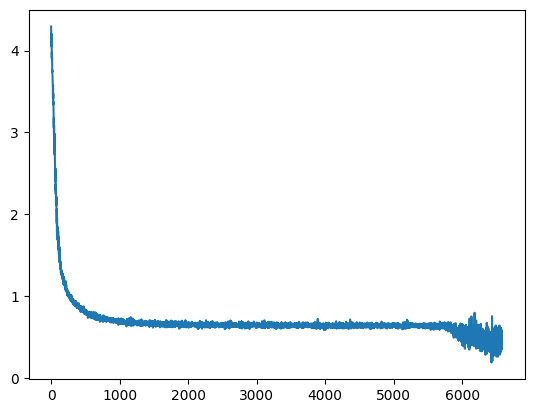

In [84]:
import matplotlib.pyplot as plt
plt.plot(losses[:len(losses)-1])
plt.show()

In [85]:
torch.save(model.state_dict(), 'model/btc15')

In [86]:
model.load_state_dict(torch.load('model/btc15'))
model.eval()

Transformer(
  (data_embedding): Linear(in_features=7, out_features=32, bias=True)
  (position_embedding): Embedding(60, 32)
  (blocks): Sequential(
    (0): Block(
      (self_att): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=32, out_features=8, bias=False)
            (query): Linear(in_features=32, out_features=8, bias=False)
            (value): Linear(in_features=32, out_features=8, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=32, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((32,), eps=1e-05, elementwise_af

In [62]:
# get previous data, run a 60 second thing through it, buy at the close, sell at the next close, evaluate
# how much money was made

request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USD"],
    timeframe=TimeFrame(amount=15, unit=TimeFrameUnit('Min')),
    #timeframe=TimeFrame.Minute,
    start="2024-05-18",
    end="2024-05-22"
)

btc_bars = client.get_crypto_bars(request_params=request_params)

dates = []
stats = []
for item in btc_bars["BTC/USD"]:
    dates.append(dict(item)['timestamp'])
    
    temp_stats = []
    for key, value in dict(item).items():
        if key not in ['timestamp', 'symbol']:
            temp_stats.append(value) 
    stats.append(temp_stats)
    
testing_data = torch.tensor(stats, device=device)

In [47]:
print(testing_data[0]) #[open, high, low, close]
print(testing_data[1])

tensor([67118.1094, 67118.1094, 66935.9922, 67000.4297,     0.0000,     0.0000,
            0.0000], device='mps:0')
tensor([66988.4375, 66989.7031, 66827.0547, 66827.0547,     0.0000,     0.0000,
            0.0000], device='mps:0')


In [87]:
cash = 1000
iterations = 0
num_sells = 0
num_buys = 0
for bar in range(len(testing_data) - time_period):
    test_context = testing_data[bar:bar+time_period].view(1, time_period, feature_space).detach().clone()
    test_target = testing_data[bar+time_period].detach().clone()
    
    buying_price = test_context[0, -1, 3].detach().clone() # closing price
    selling_price = test_target[0].detach().clone()

    #print(buying_price, selling_price)

    normalized_context = normalize_features(test_context)

    logits = model(normalized_context)
    
    print(F.softmax(logits[0, -1], dim=-1))

    decision = torch.argmax(logits[0, -1])
    
    
    if decision == 2:
        # buy signal
        #print(selling_price-buying_price)
        cash += (selling_price - buying_price)
        num_buys += 1
    elif decision == 1:
        # do nothing
        pass
    elif decision == 0:
        # sell signal
        cash += (buying_price - selling_price)
        num_sells += 1
        pass
    else:
        # error
        print("Bad")
    
    #print(cash)
    iterations += 1

    

print(f'Iterations: {iterations}, buys: {num_buys}, sells: {num_sells}')

tensor([0.2071, 0.4781, 0.3148], device='mps:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2124, 0.5148, 0.2727], device='mps:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2610, 0.4642, 0.2749], device='mps:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2592, 0.4655, 0.2753], device='mps:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2161, 0.4879, 0.2960], device='mps:0', grad_fn=<SoftmaxBackward0>)
tensor([0.1977, 0.5036, 0.2987], device='mps:0', grad_fn=<SoftmaxBackward0>)
tensor([0.1928, 0.5036, 0.3036], device='mps:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2528, 0.4821, 0.2652], device='mps:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2243, 0.4955, 0.2802], device='mps:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2028, 0.5008, 0.2964], device='mps:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2601, 0.4844, 0.2556], device='mps:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2231, 0.4913, 0.2856], device='mps:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2148, 0.4936, 0.2916], device='mps:0', grad_fn=<SoftmaxBackward0>)

In [88]:
# next steps: normalize/scale the features,,,,???? center around 0 and 1 STDEV, should be a cool way to do this in pytorch
# rewrite the code to be more clean

#back test this on some new data
print(cash)

1000
